In [1]:
import os
CUDA_VISIBLE_DEVICES_KEY = "CUDA_VISIBLE_DEVICES"
os.environ[CUDA_VISIBLE_DEVICES_KEY] = "7"

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

train_df = pd.read_csv('train.csv')
train_df

,img_path,label,type
0,train_data/1.png,3,1
1,train_data/2.png,7,3
2,train_data/3.png,9,2
3,train_data/4.png,9,1
4,train_data/5.png,10,1
...,...,...,...
2995,train_data/2996.png,10,1
2996,train_data/2997.png,2,1
2997,train_data/2998.png,7,1
2998,train_data/2999.png,7,3


In [4]:
test_df = pd.read_csv('test.csv')
test_df

,img_path
0,test_data/1.png
1,test_data/2.png
2,test_data/3.png
3,test_data/4.png
4,test_data/5.png
...,...
5995,test_data/5996.png
5996,test_data/5997.png
5997,test_data/5998.png
5998,test_data/5999.png


Removed due to excess of vertical lines
5


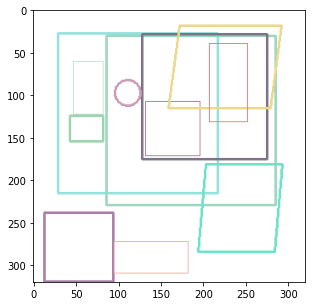

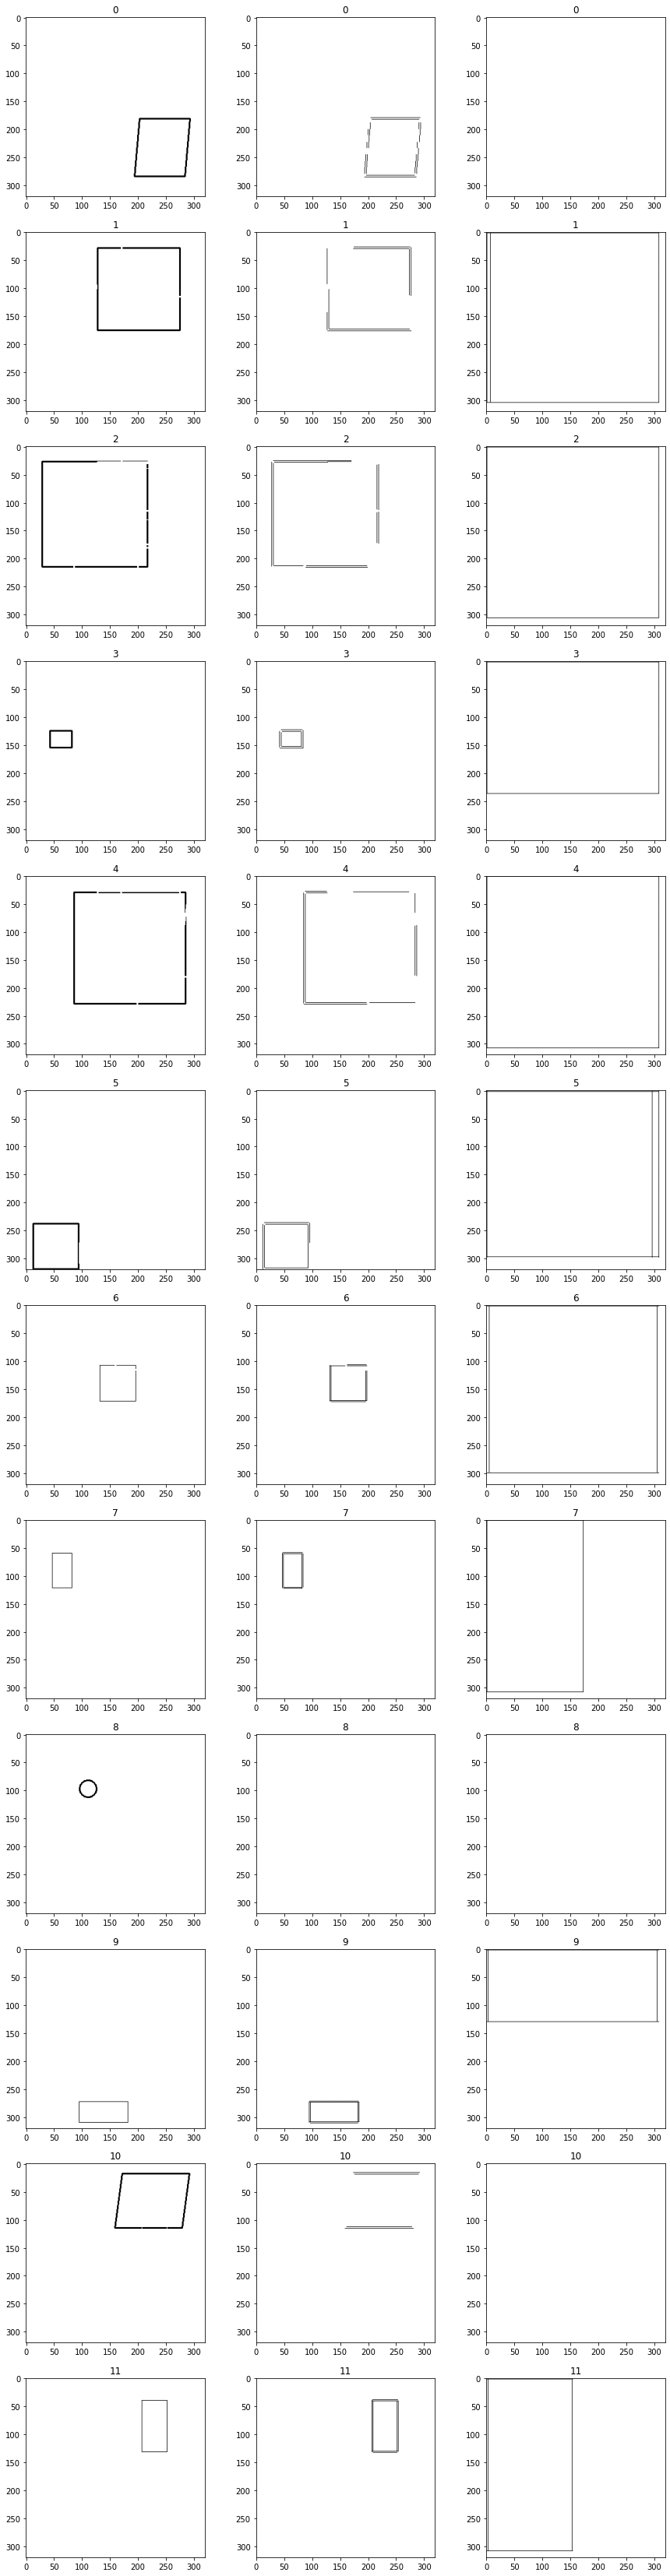

In [37]:
from gamma_util import general_util
import importlib
importlib.reload(general_util)
import time

row = train_df.iloc[406]
prepared_image = general_util.create_prepared_image(row)

plt.figure(figsize=(5,5))
plt.imshow(
    Image.fromarray(prepared_image.input_image)
)

sub_image_amount = len(prepared_image.resized_line_image_list)
fig, ax_list = plt.subplots(figsize=(15, sub_image_amount*5),ncols=3, nrows=sub_image_amount)
print(prepared_image.label)
for line_image_index, _ in enumerate(prepared_image.resized_line_image_list):
    ax_line = ax_list[line_image_index]
    ax_line[0].imshow(prepared_image.raw_sub_image_list[line_image_index], cmap='binary')
    ax_line[1].imshow(prepared_image.line_image_list[line_image_index].image_arr, cmap='binary')
    ax_line[2].imshow(prepared_image.resized_line_image_list[line_image_index].image_arr, cmap='binary')
    for ax in ax_line:
        ax.set_title(f"{line_image_index}")

In [48]:
from gamma_util import general_util
import importlib
importlib.reload(general_util)
import time

row = train_df.iloc[89]
prepared_image = general_util.create_prepared_image(row)

square_amount = 0
for resized_line_image_index, resized_line_image in enumerate(prepared_image.resized_line_image_list):
    line_list = resized_line_image.line_list
    hor_list = [line for line in line_list if general_util.is_horisontal(line)]
    ver_list = [line for line in line_list if general_util.is_vertical(line)]

    hor_distance_list = list()
    for left in hor_list:
        for right in hor_list:
            hor_distance_list.append(abs(left[1] - right[1]))
    if len(hor_distance_list) == 0:
        continue
        
    ver_distance_list = list()
    for left in ver_list:
        for right in ver_list:
            ver_distance_list.append(abs(left[0] - right[0]))
    if len(ver_distance_list) == 0:
        continue
        
    max_hor = max(hor_distance_list)
    max_ver = max(ver_distance_list)
    
    is_square = False
    if abs(max_hor - max_ver) < 6:
        square_amount += 1
        is_square = True
    print(resized_line_image_index, is_square, max_hor, max_ver)
        
print(f"Expected: {prepared_image.label}")
print(f"Actual: {square_amount}")

0 False 307 87
1 True 0 0
2 True 304 307
Expected: 1
Actual: 2


# Prod

In [7]:
from gamma_util import general_util
import importlib
importlib.reload(general_util)
import time

# prepared_image_list = list()
# for row_index, row in train_df.iterrows():
#     if row_index % 50 == 0:
#         print(row_index)
#     prepared_image = general_util.create_prepared_image(row)
#     prepared_image_list.append(prepared_image)

In [8]:
# import pickle

# with open('prepared_image_cache_v80', 'wb') as f:
#     pickle.dump(prepared_image_list, f)

In [17]:
import pickle

with open('prepared_image_cache_v80', 'rb') as f:
    prepared_image_list = pickle.load(f)
len(prepared_image_list)

3000

7
Image empty
Image empty


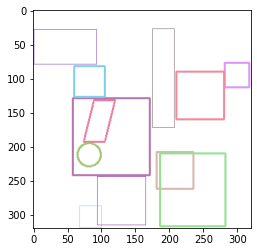

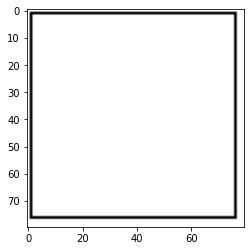

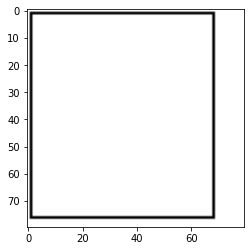

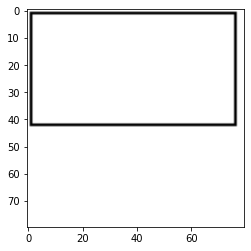

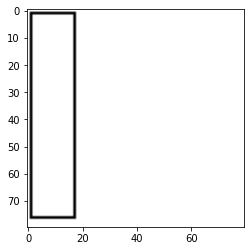

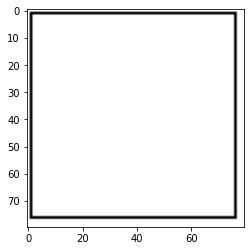

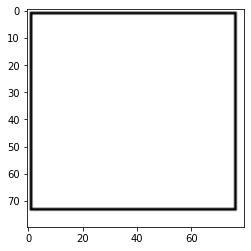

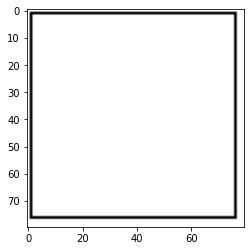

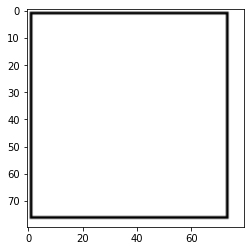

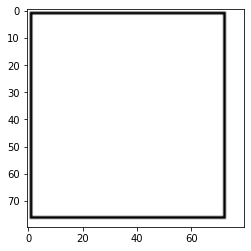

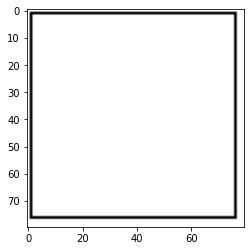

In [18]:
e = prepared_image_list[1]
plt.figure()
plt.imshow(
    Image.fromarray(e.input_image)
)
print(e.label)
for im in e.resized_line_image_list:
    if im.image_arr.sum() == 0:
        print("Image empty")
        continue
    plt.figure()
    plt.imshow(im.image_arr, cmap='binary')

In [19]:
full_line_image_array = np.zeros((
    len(prepared_image_list),
    20,
    80,
    80
))
full_label_array = np.zeros((
    len(prepared_image_list),
))
full_type_array = np.zeros((
    len(prepared_image_list),
))

for prepared_image_index, prepared_image in enumerate(prepared_image_list):
    line_image_index = 0
    for line_image in prepared_image.resized_line_image_list:
        if line_image.image_arr.sum() == 0:
            continue
        full_line_image_array[prepared_image_index, line_image_index, :, :] = line_image.image_arr
        line_image_index += 1
    assert prepared_image.label is not None
    full_label_array[prepared_image_index] = prepared_image.label
    assert prepared_image.image_type is not None
    full_type_array[prepared_image_index] = prepared_image.image_type

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
train_indices, test_eval_indices = list(kfold.split(full_line_image_array, full_type_array))[0]

In [21]:
X_train = full_line_image_array[train_indices]
train_prepared_images = np.array(prepared_image_list)[train_indices]
y_train = full_label_array[train_indices]
types_train = full_type_array[train_indices]

X_test_eval = full_line_image_array[test_eval_indices]
test_eval_prepared_images = np.array(prepared_image_list)[test_eval_indices]
y_test_eval = full_label_array[test_eval_indices]
types_test_eval = full_type_array[test_eval_indices]

In [22]:
test_kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
test_indices, eval_indices = list(test_kfold.split(X_test_eval, types_test_eval))[0]

X_test = X_test_eval[test_indices]
test_prepared_images = np.array(test_eval_prepared_images)[test_indices]
y_test = y_test_eval[test_indices]
print(X_test.shape)

X_eval = X_test_eval[eval_indices]
eval_prepared_images = np.array(test_eval_prepared_images)[eval_indices]
y_eval = y_test_eval[eval_indices]
print(X_eval.shape)

(375, 20, 80, 80)
(375, 20, 80, 80)


In [79]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers

model = models.Sequential()

model.add(layers.Conv2D(8, (5, 5), strides=2, activation='relu', input_shape=(20, 80, 80, 1)))
model.add(layers.MaxPooling3D((1, 2, 2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=regularizers.L1(l1=1e-5), padding="same"))
model.add(layers.MaxPooling3D((1, 2, 2)))

# model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.L1(l1=1e-5), padding="same"))
# model.add(layers.MaxPooling3D((1, 2, 2)))

# model.add(layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=regularizers.L1(l1=1e-5), padding="same"))
# model.add(layers.MaxPooling3D((1, 2, 2)))

# model.add(layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=regularizers.L1(l1=1e-5), padding="same"))
# model.add(layers.MaxPooling3D((1, 3, 3)))

# model.add(layers.Dropout(.2))

model.add(layers.Reshape((1, 20, -1)))
model.add(layers.Permute((2, 3, 1)))
model.add(layers.Conv2D(10, (1, 648)))
model.add(layers.Permute((1, 3, 2)))
model.add(layers.Conv2D(1, (1,10)))

model.add(layers.AveragePooling2D((20,1)))
model.add(layers.Flatten())

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
)
print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 20, 80, 80, 1)
(None, 1)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 20, 38, 38, 8)     208       
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 20, 19, 19, 8)    0         
 g3D)                                                            
                                                                 
 conv2d_105 (Conv2D)         (None, 20, 19, 19, 8)     584       
                                                                 
 max_pooling3d_57 (MaxPoolin  (None, 20, 9, 9, 8)      0         
 g3D)                                                            
                                                                 
 reshape_26 (Reshape)        (None, 1, 20, 648)        0         
                                                                 
 permute_49 (Permute)

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint 
checkpoint = ModelCheckpoint(
    filepath='best_model_{epoch:02d}-{val_loss:.2f}.hdf5',
    save_best_only=True,
)

In [81]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(
        X_eval,
        y_eval,
    ),
    epochs=100, 
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/100
71/71 [==============================] - 2s 14ms/step - loss: 12.9444 - val_loss: 3.0028
Epoch 2/100
71/71 [==============================] - 1s 11ms/step - loss: 1.6563 - val_loss: 0.9484
Epoch 3/100
71/71 [==============================] - 1s 11ms/step - loss: 0.7103 - val_loss: 0.6440
Epoch 4/100
71/71 [==============================] - 1s 10ms/step - loss: 0.4687 - val_loss: 0.4104
Epoch 5/100
71/71 [==============================] - 1s 12ms/step - loss: 0.3125 - val_loss: 0.2622
Epoch 6/100
71/71 [==============================] - 1s 10ms/step - loss: 0.2120 - val_loss: 0.1833
Epoch 7/100
71/71 [==============================] - 1s 11ms/step - loss: 0.1669 - val_loss: 0.1563
Epoch 8/100
71/71 [==============================] - 1s 10ms/step - loss: 0.1519 - val_loss: 0.1449
Epoch 9/100
71/71 [==============================] - 1s 10ms/step - loss: 0.1442 - val_loss: 0.1401
Epoch 10/100
71/71 [==============================] - 1s 10ms/step - loss: 0.1403 - val_loss: 0.132

In [82]:
y_pred = model.predict(
    X_test,
)[:,0]
y_pred = np.round(y_pred)

12/12 [==============================] - 0s 4ms/step


In [83]:
from sklearn.metrics import mean_squared_error

# 2.525
# 2.39
# 2.21
# 1.664
# 0.35
# 0.224
mse = mean_squared_error(y_test, y_pred)
mse

0.13066666666666665

Expected: 8
Actual: 8.0


<ipython-input-84-4857c0376e4b>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


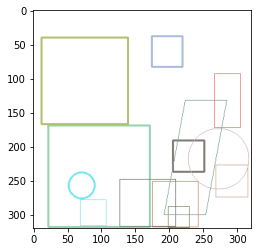

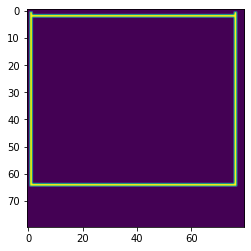

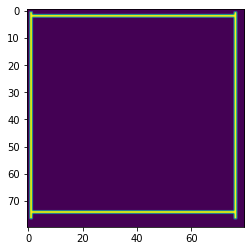

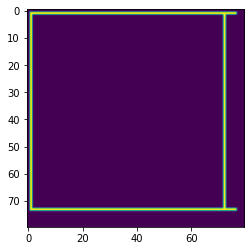

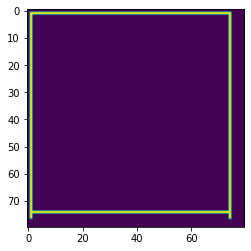

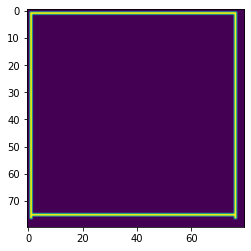

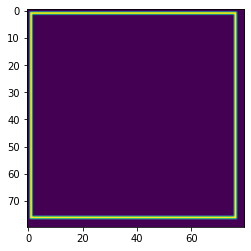

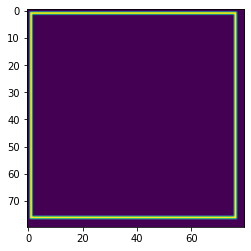

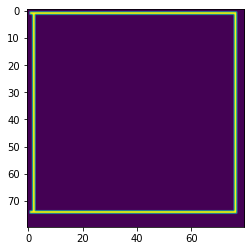

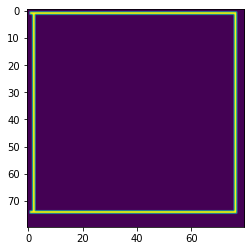

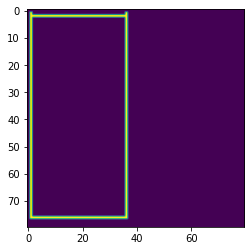

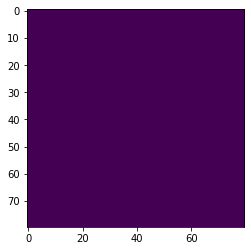

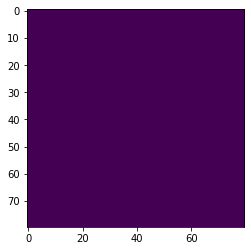

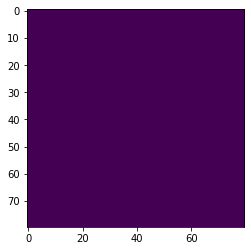

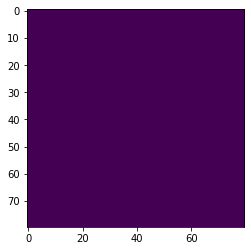

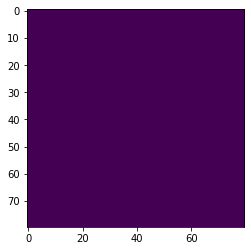

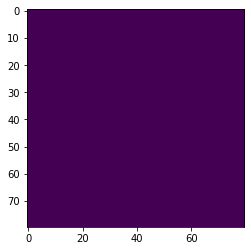

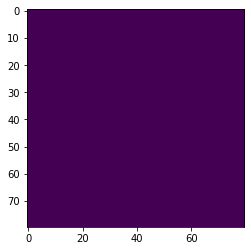

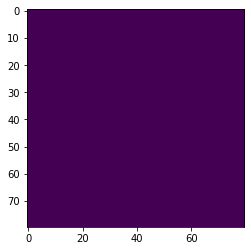

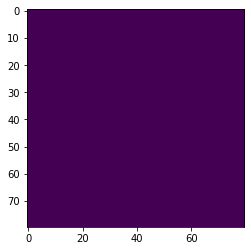

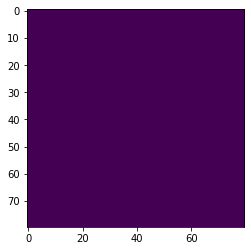

In [84]:
chosen_test_image = 18

print(f"Expected: {test_prepared_images[chosen_test_image].label}")
print(f"Actual: {y_pred[chosen_test_image]}")
plt.imshow(
    Image.fromarray(test_prepared_images[chosen_test_image].input_image)
)
for sub_image in X_test[chosen_test_image]:
    plt.figure()
    plt.imshow(sub_image)

In [459]:
# model.save("real_best_model_today_v6_09.hdf5", include_optimizer=True)

In [460]:
# !cp real_best_model_today_v4.hdf5 /aux/data

0.8853333333333333


 0.0    332
 1.0     27
-1.0     14
 2.0      2
dtype: int64

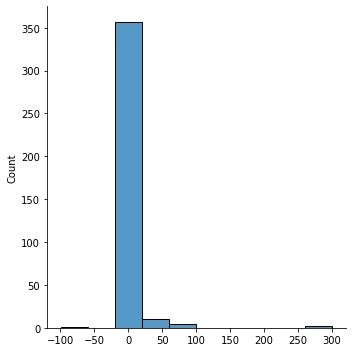

In [85]:
import seaborn as sns
y_diff = y_pred - y_test
y_percent = ((y_diff / (y_test+0.01)) * 100).astype(np.int32)

sns.displot(np.clip(y_percent, -300, 300))
y_diff_counts = pd.value_counts(y_diff)
print(y_diff_counts[0] / y_diff_counts.sum())
y_diff_counts[y_diff_counts.abs().sort_values(ascending=False).index]

In [86]:
y_diff_s = pd.Series(y_diff)
y_diff_s = y_diff_s[y_diff_s.abs() == 1]
bad_test_indices = sorted(y_diff_s.index.to_list())
# bad_test_indices

In [87]:
original_indices = np.arange(len(prepared_image_list))
bad_test_indices_original = original_indices[test_eval_indices][test_indices][bad_test_indices]
bad_test_indices_original.shape

(41,)

In [88]:
bad_test_indices_original

array([  91,  233,  395,  489,  515,  570,  642,  727,  769,  872,  980,
        998, 1240, 1369, 1384, 1385, 1775, 1828, 1836, 1891, 1918, 1963,
       2114, 2128, 2130, 2143, 2167, 2223, 2231, 2246, 2277, 2396, 2404,
       2637, 2658, 2670, 2765, 2818, 2887, 2891, 2908])

Expected: 5
Actual: 7.0


<ipython-input-465-5336341e6822>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


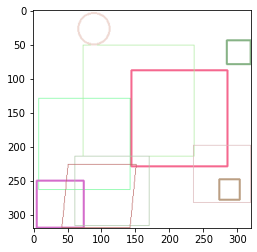

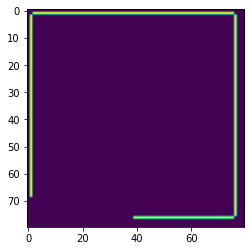

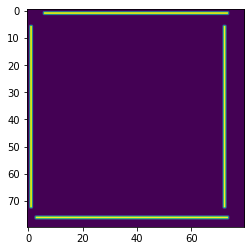

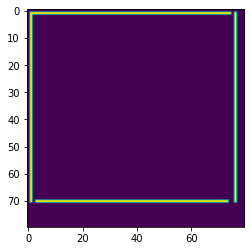

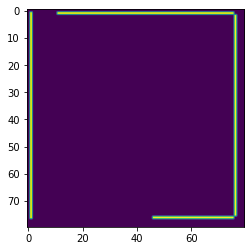

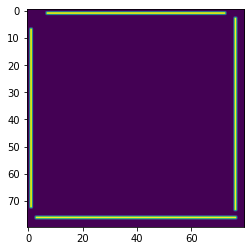

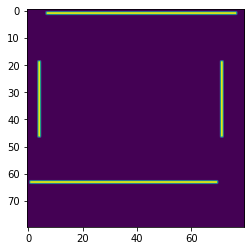

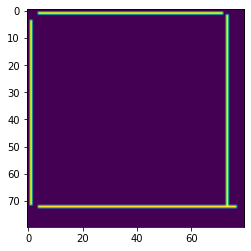

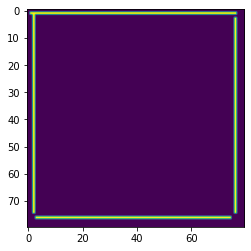

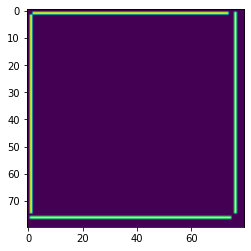

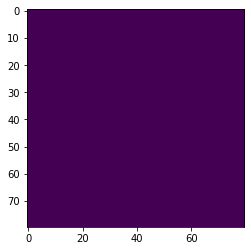

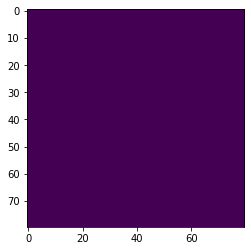

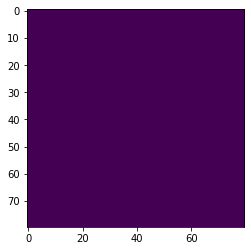

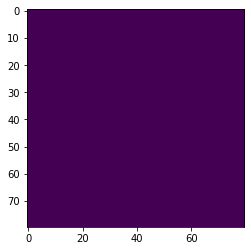

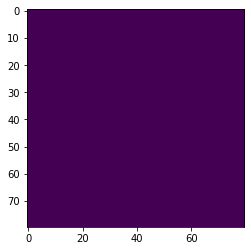

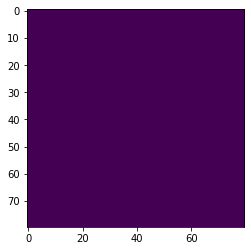

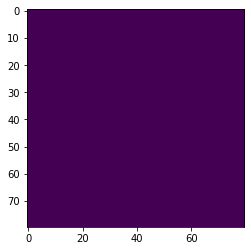

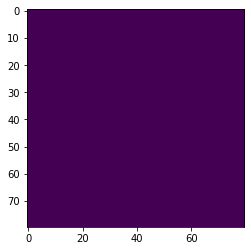

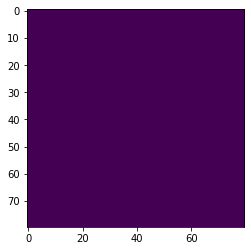

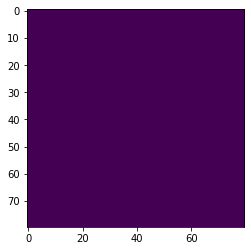

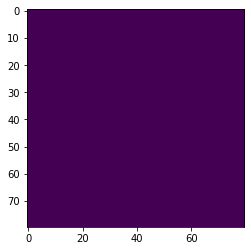

In [465]:
chosen_test_image = 241

print(f"Expected: {test_prepared_images[chosen_test_image].label}")
print(f"Actual: {y_pred[chosen_test_image]}")
plt.imshow(
    Image.fromarray(test_prepared_images[chosen_test_image].input_image)
)
for sub_image in X_test[chosen_test_image]:
    plt.figure()
    plt.imshow(sub_image)

# Submit

In [ ]:
assert False

In [466]:
from gamma_util import general_util
import importlib
importlib.reload(general_util)
import time

start_time = time.time()
submit_prepared_image_list = list()
for row_index, row in test_df.iterrows():
    if row_index % 50 == 0:
        print(f"{row_index}/{len(test_df)}, elapsed: {int((time.time() - start_time))}")
    prepared_image = general_util.create_prepared_image(row)
    submit_prepared_image_list.append(prepared_image)

0/6000, elapsed: 0
Removed due to excess of vertical lines
50/6000, elapsed: 6
Removed due to excess of vertical lines
Removed due to excess of vertical lines
100/6000, elapsed: 12
Removed due to excess of vertical lines
Removed due to excess of vertical lines
Removed due to excess of vertical lines
Removed due to excess of vertical lines
150/6000, elapsed: 18
Removed due to excess of vertical lines
Removed due to excess of vertical lines
200/6000, elapsed: 25
Removed due to excess of vertical lines
Removed due to excess of vertical lines
Removed due to excess of vertical lines
Removed due to excess of vertical lines
Removed due to excess of vertical lines
Removed due to excess of vertical lines
250/6000, elapsed: 31
Removed due to excess of vertical lines
300/6000, elapsed: 36
Removed due to excess of vertical lines
350/6000, elapsed: 43
Removed due to excess of vertical lines
400/6000, elapsed: 49
450/6000, elapsed: 55
Removed due to excess of vertical lines
Removed due to excess of 

In [469]:
# import pickle

# with open('submit_prepared_image_cache_v80', 'wb') as f:
#     pickle.dump(submit_prepared_image_list, f)

In [17]:
# !cp submit_prepared_image_cache_v80 /aux/data

In [18]:
# import pickle

# with open('submit_prepared_image_cache_v2', 'rb') as f:
#     submit_prepared_image_list = pickle.load(f)
# len(submit_prepared_image_list)

In [470]:
import numpy as np

submit_full_line_image_array = np.zeros((
    len(submit_prepared_image_list),
    20,
    80,
    80
))
submit_full_label_array = np.zeros((
    len(submit_prepared_image_list),
))
submit_full_type_array = np.zeros((
    len(submit_prepared_image_list),
))

clip_amount = 0
for prepared_image_index, prepared_image in enumerate(submit_prepared_image_list):
    line_image_index = 0
    for line_image in prepared_image.resized_line_image_list:
        if line_image.image_arr.sum() == 0:
            continue
        if line_image_index >= 20:
            clip_amount += 1
            continue
        submit_full_line_image_array[prepared_image_index, line_image_index, :, :] = line_image.image_arr
        line_image_index += 1
#     assert prepared_image.label is not None
#     submit_full_label_array[prepared_image_index] = prepared_image.label
#     assert prepared_image.image_type is not None
#     submit_full_type_array[prepared_image_index] = prepared_image.image_type

print(f"Totally clipped: {clip_amount}")

Totally clipped: 0


In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('real_best_model_today_v3.hdf5')

In [471]:
all_indices = np.arange(len(submit_full_line_image_array))
index_part_list = np.array_split(all_indices, 12)
print(len(index_part_list))
print(len(index_part_list[0]))

12
500


In [472]:
pred_list = list()

for index_part in index_part_list:
    submit_y_pred = model.predict(
        submit_full_line_image_array[index_part][:,:,:,:,np.newaxis]
    )[:,0]
    submit_y_pred = np.round(submit_y_pred)
    pred_list.append(submit_y_pred)
    print("Done")

16/16 [==============================] - 0s 18ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 1s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done
16/16 [==============================] - 0s 13ms/step
Done


Actual: 7.0


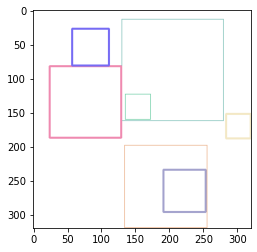

In [476]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

chosen_index = 0
actual = pred_list[0][chosen_index]
print(f"Actual: {actual}")
im = submit_prepared_image_list[chosen_index]
plt.figure()
plt.imshow(
    Image.fromarray(im.input_image)
)

In [477]:
submit_list = list()
for part in pred_list:
    submit_list += list(part)
len(submit_list)

6000

In [478]:
import pandas as pd
final_series = pd.Series(submit_list).astype(np.int32)
final_series

0        7
1       16
2        2
3        6
4        9
        ..
5995    15
5996    14
5997    16
5998     8
5999     2
Length: 6000, dtype: int32

In [479]:
final_df = final_series.to_frame()
final_df.columns = ['label']
final_df.to_csv('submit_81.csv', index=False)

In [480]:
!head -n 10 submit_81.csv

label
7
16
2
6
9
4
15
17
10
